## Download library

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from transformers import BertTokenizer, TFBertModel
import tensorflow as tf

## Download data

In [3]:
train = pd.read_csv('/train.csv')

## Preliminary analyse

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12120 entries, 0 to 12119
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          12120 non-null  object
 1   premise     12120 non-null  object
 2   hypothesis  12120 non-null  object
 3   lang_abv    12120 non-null  object
 4   language    12120 non-null  object
 5   label       12120 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 568.2+ KB


In [5]:
train.isna().sum()

id            0
premise       0
hypothesis    0
lang_abv      0
language      0
label         0
dtype: int64

In [6]:
train.sample(5)

,id,premise,hypothesis,lang_abv,language,label
4363,bd97228e37,"Normally, these discussions are kept secret.",These discussions involve a secret plan to tak...,en,English,1
11299,b85f03e268,टाईम दो विरोधी भावनाओं के लेख चलाता है।,न्यूज़वीक चार बहुत भावनात्मक लेख लिखता है।,hi,Hindi,2
3075,4a56e9e885,¿No es extraño que no prestemos atención a uno...,¿No miramos algo tan increíble?,es,Spanish,0
3460,5e8caf2c41,The Throne Room is one of a series of apartmen...,The Throne Room is available for tours daily.,en,English,1
2146,a4939001a4,Номерът е да мисля за себе си по-малко като за...,Приемам подхода на спазване на закона и реда и...,bg,Bulgarian,2


In [7]:
train.language.value_counts()

English       6870
Chinese        411
Arabic         401
French         390
Swahili        385
Urdu           381
Vietnamese     379
Russian        376
Hindi          374
Greek          372
Thai           371
Spanish        366
Turkish        351
German         351
Bulgarian      342
Name: language, dtype: int64

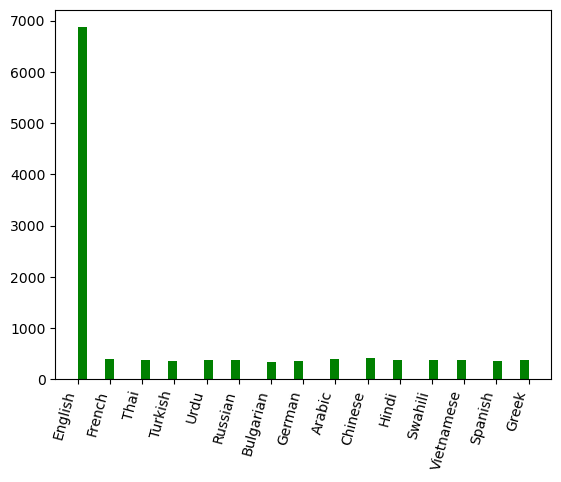

In [8]:
plt.hist(train.language, bins=50, color='green')
plt.xticks(rotation=75, horizontalalignment="right")
plt.show()

In [9]:
train.label.value_counts()

0    4176
2    4064
1    3880
Name: label, dtype: int64

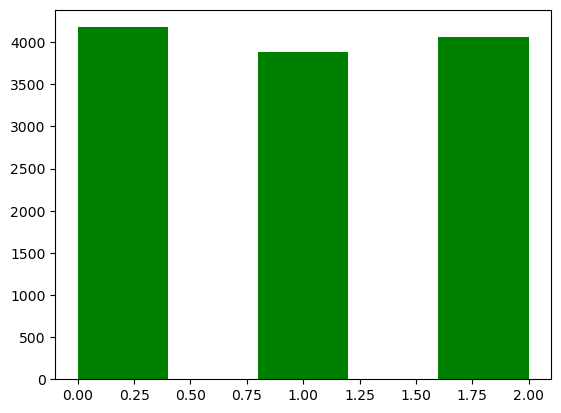

In [10]:
plt.hist(train.label, bins=5, color='green')
plt.show()

In [11]:
train.loc[train['lang_abv']=='en']['premise'].values[23]

'The four Javis children? asked Severn.'

In [12]:
train.loc[train['lang_abv']=='en']['hypothesis'].values[23]

'Severn knows everything about the Jarvis children.'

In [13]:
train.loc[train['lang_abv']=='en']['label'].values[23]

1

## Preparing data for input

In [14]:
model_name = 'bert-base-multilingual-cased'
tokenizer = BertTokenizer.from_pretrained(model_name)

In [15]:
def encode_sentence(s):
    tokens = list(tokenizer.tokenize(s))
    tokens.append('[SEP]')
    return tokenizer.convert_tokens_to_ids(tokens)

In [16]:
def bert_encode(premises,hypotheses,tokenizer):
    
    num_examples = len(hypotheses)

    sentence1 = tf.ragged.constant([encode_sentence(s) for s in np.array(hypotheses)])
    sentence2 = tf.ragged.constant([encode_sentence(s) for s in np.array(premises)])

    cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence1.shape[0]
    input_word_ids = tf.concat([cls, sentence1, sentence2], axis=-1)

    input_mask = tf.ones_like(input_word_ids).to_tensor()

    type_cls = tf.zeros_like(cls)
    type_s1 = tf.zeros_like(sentence1)
    type_s2 = tf.ones_like(sentence2)
    input_type_ids = tf.concat([type_cls, type_s1, type_s2], axis=-1).to_tensor()

    inputs = {
        'input_word_ids': input_word_ids.to_tensor(),
        'input_mask': input_mask,
        'input_type_ids': input_type_ids}

    return inputs

In [17]:
train_input = bert_encode(train.premise.values, train.hypothesis.values, tokenizer)

In [18]:
train_input

{'input_word_ids': <tf.Tensor: shape=(12120, 259), dtype=int32, numpy=
 array([[  101, 10117, 23123, ...,     0,     0,     0],
        [  101, 46184, 15647, ...,     0,     0,     0],
        [  101,   147,   112, ...,     0,     0,     0],
        ...,
        [  101, 10377, 25259, ...,     0,     0,     0],
        [  101, 10117, 13192, ...,     0,     0,     0],
        [  101, 68795, 15698, ...,     0,     0,     0]], dtype=int32)>,
 'input_mask': <tf.Tensor: shape=(12120, 259), dtype=int32, numpy=
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>,
 'input_type_ids': <tf.Tensor: shape=(12120, 259), dtype=int32, numpy=
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 

In [19]:
def build_model():
    bert_encoder = TFBertModel.from_pretrained(model_name)
    input_word_ids = tf.keras.Input(shape = (None,),dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape = (None,),dtype=tf.int32, name="input_mask")
    input_type_ids = tf.keras.Input(shape = (None,),dtype=tf.int32, name="input_type_ids")
    
    embedding = bert_encoder([input_word_ids, input_mask, input_type_ids])[0]
    output = tf.keras.layers.Dense(3, activation='softmax')(embedding[:,0,:])
    
    model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=output)
    model.compile(tf.keras.optimizers.Adam(lr=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [20]:
model = build_model()
model.summary()

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 input_type_ids (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  177853440   ['input_word_ids[0][0]',         
                                thPoolingAndCrossAt               'input_mask[0][0]',         

In [21]:
model.fit(train_input, train.label.values, epochs = 2, verbose = 1, batch_size = 16, validation_split = 0.2)

Epoch 1/2
606/606 [==============================] - 622s 964ms/step - loss: 1.2015 - accuracy: 0.3378 - val_loss: 1.1133 - val_accuracy: 0.3449
Epoch 2/2
606/606 [==============================] - 548s 905ms/step - loss: 1.1233 - accuracy: 0.3376 - val_loss: 1.1073 - val_accuracy: 0.3441


In [22]:
test = pd.read_csv('test.csv')
test_input = bert_encode(test.premise.values, test.hypothesis.values, tokenizer)

In [23]:
predictions = [np.argmax(i) for i in model.predict(test_input)]

163/163 [==============================] - 83s 489ms/step


In [24]:
submission = test.id.copy().to_frame()
submission['prediction'] = predictions

In [25]:
submission.to_csv("submission.csv", index = False)